# Kerchunk and Pangeo-Forge

In this tutorial we are going to use Kerchunk to create reference files of a dataset. This allows us to read an entire dataset as if it were a single Zarr store instead of a collection of NetCDF files. Using Kerchunk, we don't have to create a copy of the data, instead we create a collection of reference files, so that the original data files can be read as if they were Zarr.

In addition to using Kerchunk, we will be using `Pangeo-Forge` as a recipe runner.  


## Getting to Know The Data

gridMET is a high-resolution daily meteorological dataset covering CONUS from 1979-2023. It is produced by the Climatology Lab at UC Merced. In this example, we are going to look create a virtual Zarr dataset of a derived variable, Burn Index. 

### Examine a Single File

In [18]:
import xarray as xr

ds = xr.open_dataset(
    "http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/bi/bi_2021.nc"
)

In [121]:
round(ds.nbytes / 1e9, 1)

2.4

It looks like a single year is about 2.4GB. For 45 years of data, that's about 108GB of data for a single variable.

In [ ]:
ds.sel(day="2021-08-01").burning_index_g.plot()

## Create a File Pattern

To build our `pangeo-forge` pipeline, we need to create a FilePattern object, which is composed of all of our input urls. This dataset ranges from 1979 through 2023 and is composed of one year per file. 

In [116]:
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
from pangeo_forge_recipes import patterns

years = list(range(1979, 2023 + 1))
time_dim = ConcatDim("time", keys=years)


def format_function(time):
    return f"http://www.northwestknowledge.net/metdata/data/bi_{time}.nc"


pattern = FilePattern(format_function, time_dim, file_type="netcdf4")
pattern

<FilePattern {'time': 45}>

## Create a Location For Output
For this example, we are creating a temporary directory to write the data to. If we wanted to persist this Kerchunk reference, we could write to local disc or cloud storage. 

In [75]:
import os
from tempfile import TemporaryDirectory

td = TemporaryDirectory()
target_root = td.name
store_name = "esip"
target_store = os.path.join(target_root, store_name)

## Build the Pangeo-Forge Beam Pipeline

Next, we will chain together a bunch of methods to create a Pangeo-Forge - Apache Beam pipeline. 
Processing steps are chained together with the pipe operator (`|`). Once the pipeline is built, it can be ran in the following cell. 

The steps are as follows:
1. Creates a starting collection of our input file patterns.
2. Passes those file_patterns to `OpenWithKerchunk`, which creates references of each file.
3. Combines the references files into a single reference file with `CombineReferences`.
4. Writes the combined reference file.

Note: You can add additional processing steps in this pipeline. 


In [76]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import (
    OpenWithKerchunk,
    CombineReferences,
    WriteCombinedReference,
)

transforms = (
    # Create a beam PCollection from our input file pattern
    beam.Create(pattern.items())
    # Open with Kerchunk and create references for each file
    | OpenWithKerchunk(file_type=pattern.file_type)
    # Use Kerchunk's `MultiZarrToZarr` functionality to combine the reference files into a single
    # reference file. *Note*: Setting the correct contact_dims and identical_dims is important.
    | CombineReferences(
        concat_dims=["day"],
        identical_dims=["lat", "lon", "crs"],
    )
    # Write the combined Kerchunk reference to file.
    | WriteCombinedReference(target_root=target_root, store_name=store_name)
)

In [77]:
with beam.Pipeline() as p:
    p | transforms

In [126]:
import os

print(os.path.getsize(full_path) / 1e6)

48115

Our reference .json file is about 1MB, instead of 108GBs. That is quite the storage savings! 

## Examine the Result

In [80]:
full_path = os.path.join(target_root, store_name, "reference.json")
mapper = fsspec.get_mapper(
    "reference://",
    fo=full_path,
    remote_protocol="http",
)
ds = xr.open_dataset(
    mapper, engine="zarr", decode_coords="all", backend_kwargs={"consolidated": False}
)

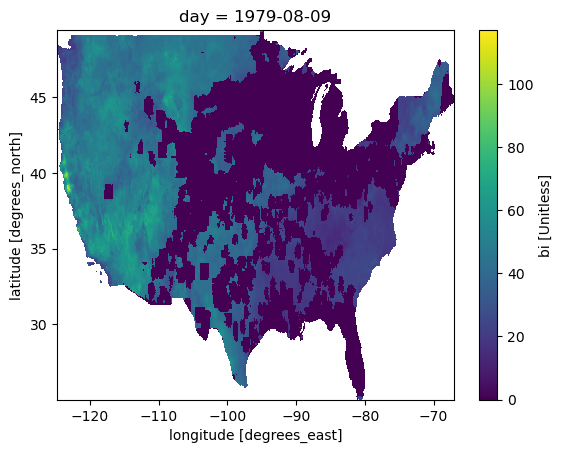

In [89]:
ds.isel(day=220).burning_index_g.plot()